# 6. Energy based model

In [1]:
import tensorflow as tf
tf.__version__

2025-11-19 21:39:04.367777: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-19 21:39:06.273551: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-19 21:39:09.183864: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


'2.20.0'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.losses import KLDivergence
from scipy.spatial.distance import jensenshannon
import scipy.stats as stats
import scipy
from functools import partial

In [4]:
n_samples = 10000
X, _ = make_moons(n_samples=n_samples, noise=0.05)
X.shape

(10000, 2)

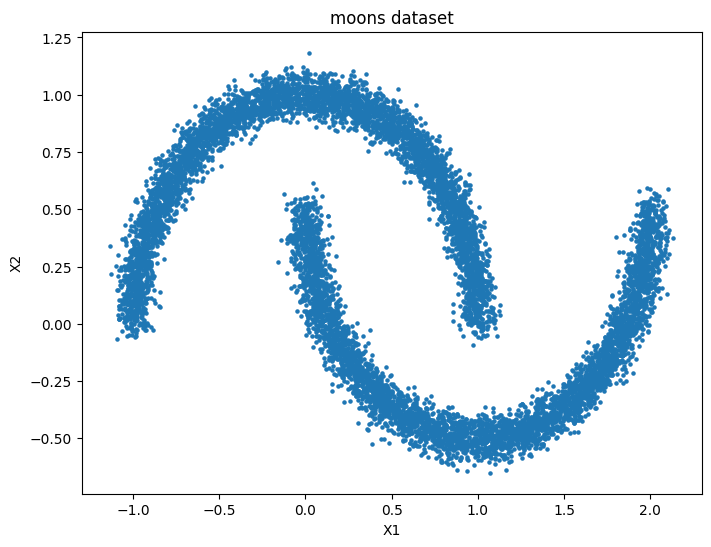

In [5]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=5)
plt.title('moons dataset')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [6]:
def create_contour_plot(f, transpose=False):
    num_points = 250
    x_surface = np.linspace(-3, 3, num_points)
    y_surface = np.linspace(-3, 3, num_points)
    X, Y = np.meshgrid(x_surface, y_surface)
    combined = np.vstack((X.flatten(), Y.flatten())).T
    if transpose:
        
        Z = f(combined.T)
    else:
        Z = f(combined)
    plt.contourf(X, Y, Z.reshape(X.shape), levels=20)
    plt.colorbar()
    plt.show()
    return Z

 
def create_contour_plot_tensorflow(E):
    num_points = 250
    x_surface = np.linspace(-3, 3, num_points)
    y_surface = np.linspace(-3, 3, num_points)
    X, Y = np.meshgrid(x_surface, y_surface)
    combined = np.vstack((X.flatten(), Y.flatten())).T
    combined = tf.convert_to_tensor(combined, dtype=tf.float32)
    Z = E(combined).numpy()
    plt.contourf(X, Y, Z.reshape(X.shape), levels=20)
    plt.colorbar()
    plt.show()

In [7]:
def make_pdf_data(data, bw_method=0.15):
    kernel = scipy.stats.gaussian_kde(data.T, bw_method=bw_method)
    pdf_kde = create_contour_plot(kernel, transpose=True)
    pdf_kde = pdf_kde / pdf_kde.sum()
    return pdf_kde

    
def make_pdf_energy(E):
    num_points = 250
    x = np.linspace(-3, 3, num_points)
    y = np.linspace(-3, 3, num_points)
    X, Y = np.meshgrid(x, y)
    combined = np.vstack((X.flatten(), Y.flatten())).T
    combined = tf.convert_to_tensor(combined, dtype=tf.float32)
    Z = np.exp(-E(combined).numpy().reshape(num_points, num_points))
    partition = np.sum(Z)
    pdf = Z / partition
    plt.contourf(X, Y, pdf.reshape(X.shape), levels=1000)
    plt.colorbar()
    return pdf

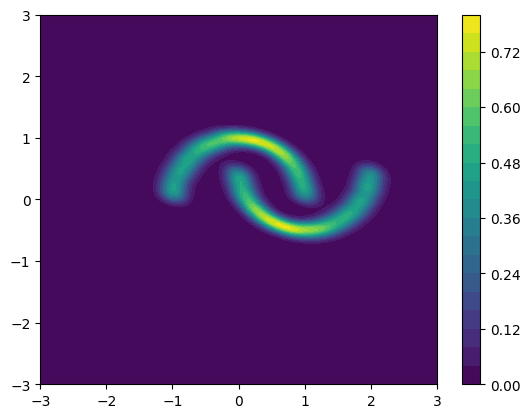

In [8]:
pdf_kde = make_pdf_data(X)

In [9]:
@tf.function
def sgld_sample(E, x_initial, num_steps, step_size, 
                std_dev, clip_thresh=tf.constant(0.1)):
    """
    Do SGLD (stochastic gradient Langevin dynamics) sampling step
    :param E: Energy function
    :param x_initial: initial sample position, of shape 
        (batch_size, ndims)
    :param num_steps: number of sampling steps
    :param step_size: step size used in gradient part
    :param std_dev: standard deviation for isotropic Gaussian 
        used in update
    :param clip_thresh: threshold for gradient clipping; prevents 
        energy gradients from growing too large
    :return: new sample
    """
    x_k = x_initial
    for _ in range(num_steps):
        with tf.GradientTape() as g:
            g.watch(x_k)
            energy = tf.math.reduce_sum(E(x_k))
        # обрезка градиента
        dE_dx = tf.clip_by_norm(g.gradient(energy, x_k), clip_thresh) 
        x_k = x_k - (step_size / 2) * dE_dx + \
            tf.random.normal(x_k.shape, mean=0.0, stddev=std_dev)
    return x_k

2025-11-19 21:41:48.801012: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [10]:
class EBM:
    def __init__(self, energy_fn, replay_buffer_size=10000):
        self.energy = energy_fn
        self.replay_buffer = []
        self.replay_buffer_ptr = 0
        self.replay_buffer_max = replay_buffer_size
    
    def sample_sgld(self, x_init, batch_size, 
                    num_steps_markov=tf.constant(25), 
                    step_size=tf.constant(10.0), 
                    std_dev=tf.constant(0.005), 
                    clip_thresh=tf.constant(0.01)):
        return sgld_sample(self.energy, x_init, num_steps_markov, 
                           step_size, std_dev, clip_thresh=clip_thresh)


    def sample_replay_buffer(self, batch_size, uniform_bounds_lower, 
                             uniform_bounds_upper,
                             num_steps_markov=tf.constant(25), 
                             step_size=tf.constant(10.0),
                             std_dev=tf.constant(0.005), 
                             clip_thresh=tf.constant(0.01)):
        # Choose initial points, either from replay buffer or 
        # from uniform distribution with bounds given by the user
        initial_points = []
        for _ in range(batch_size):
            prob_replay = np.random.uniform()
            if len(self.replay_buffer)<batch_size or prob_replay>=0.95:
                x_k = np.random.uniform(uniform_bounds_lower, 
                                        uniform_bounds_upper, (1, 2))
            else:
                x_k_index = np.random.choice(len(self.replay_buffer))
                x_k = tf.reshape(self.replay_buffer[x_k_index], 
                    (1, self.replay_buffer[x_k_index].shape[-1]))
            x_k = tf.convert_to_tensor(x_k, dtype=tf.float32)
            initial_points.append(x_k)
        initial_points = tf.concat(initial_points, 0)

        return sgld_sample(self.energy, initial_points, 
                           num_steps_markov, step_size,
                           std_dev, clip_thresh=clip_thresh)

    def _insert_into_replay_buffer(self, data, batch_size):
        for j in range(batch_size):
            if len(self.replay_buffer) <= self.replay_buffer_max:
                self.replay_buffer.append(tf.reshape(data[j], 
                                          (1, data[j].shape[-1])))
            else:
                self.replay_buffer[self.replay_buffer_ptr] = \
                    tf.reshape(data[j], (1, data[j].shape[-1]))
            self.replay_buffer_ptr += 1
            if self.replay_buffer_ptr > self.replay_buffer_max - 1:
                self.replay_buffer_ptr = 0

    def fit(self, data, batch_size, num_epochs, optimizer, 
            uniform_bounds_lower, uniform_bounds_upper,
            alpha=tf.constant(0.1), num_steps_markov=tf.constant(25), 
            step_size=tf.constant(10.0), std_dev=tf.constant(0.005), 
            clip_thresh=tf.constant(0.01), callbacks_energy=[]):
        # Get number of training examples
        n_train = data.shape[0]
        inner_loop_iterations = n_train // batch_size

        # Create dataset sampler
        dataset = tf.data.Dataset.from_tensor_slices(data)
        dataset = dataset.shuffle(buffer_size=n_train)
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.repeat()
        dataset_iterator = iter(dataset)

        for epoch in range(num_epochs):
            num_samples_processed = 0

            used_std_dev = std_dev
            if callable(std_dev):
                used_std_dev = std_dev(epoch)

            for i in range(inner_loop_iterations):
                avg_abs_diff_energies_data_sample = 0.0
                # Sample from data distribution
                sample_data_dist = next(dataset_iterator)

                # Sample from energy function
                sample_energy_dist = self.sample_replay_buffer(
                    batch_size, 
                    uniform_bounds_lower, 
                    uniform_bounds_upper, 
                    num_steps_markov=num_steps_markov, 
                    step_size=step_size,
                    std_dev=used_std_dev, 
                    clip_thresh=clip_thresh
                )
                self._insert_into_replay_buffer(
                    sample_energy_dist, batch_size
                )

                # Compute parameter gradients
                with tf.GradientTape() as g:
                    energies_data = self.energy(
                        sample_data_dist, training=True
                    )
                    energies_samples = self.energy(
                        sample_energy_dist, training=True
                    )
                    energy_data = tf.math.reduce_mean(energies_data)
                    energy_samples = tf.math.reduce_mean(
                        energies_samples
                    )
                    energies_l2 = \
                        tf.math.reduce_mean(tf.square(energies_data)) + \
                        tf.math.reduce_mean(tf.square(energies_samples))
                    energy = energy_data - energy_samples + \
                        alpha * energies_l2
                gradient = g.gradient(energy, 
                                      self.energy.trainable_variables)

                # Apply gradients
                optimizer.apply_gradients(zip(gradient, 
                    self.energy.trainable_variables))

                # Report epoch progress, compute metrics
                avg_abs_diff_energies_data_sample += \
                    (1 / inner_loop_iterations) * \
                    (tf.abs(energy_data - energy_samples)).numpy()

                num_samples_processed += batch_size
                progress = num_samples_processed / n_train

                print("\rEpoch {:2d}".format(epoch),
                      "progress: {:6.2f}%".format(
                    progress * 100.0), end='  ')
                # Print progress metric
                print("CD: {:12.10f}".format(
                    avg_abs_diff_energies_data_sample), end='  ')

            for callbacks_name, callback_fn in callbacks_energy:
                print(callbacks_name, 
                      ": {:12.10f}".format(callback_fn(self.energy)))

In [11]:
input_ = x = layers.Input(shape=X.shape[1:])
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dense(1000, activation="relu")(x)
output = layers.Dense(1)(x)
model = models.Model(inputs=[input_], outputs=[output])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │         3,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,005,001 (3.83 MB)

 Trainable params: 1,005,001 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
def jensen_shannon_distance_kde(energy, pdf_kde):
    num_points = 250
    x = np.linspace(-3, 3, num_points)
    y = np.linspace(-3, 3, num_points)
    X, Y = np.meshgrid(x, y)
    combo = np.vstack((X.flatten(), Y.flatten())).T
    combo = tf.convert_to_tensor(combo, dtype=tf.float32)
    Z = np.exp(-energy(combo).numpy().reshape(num_points, num_points))
    partition = np.sum(Z)
    pdf = Z / partition
    return scipy.spatial.distance.jensenshannon(pdf.flatten(), 
                                                pdf_kde.flatten())

In [13]:
ebm = EBM(model)

ebm.fit(
    data=X,
    batch_size=128,
    num_epochs=15,
    optimizer=optimizers.Adam(1e-3),
    uniform_bounds_lower=[-4,-4],
    uniform_bounds_upper=[4,4],
    num_steps_markov=tf.constant(10),
    std_dev=0.05,
    step_size=0.2,
    callbacks_energy = [
        ("JSD", partial(jensen_shannon_distance_kde, pdf_kde=pdf_kde))
    ],
    alpha=0.1,
    clip_thresh=tf.constant(1.0),
)

Epoch  0 progress:  99.84%  CD: 0.0725116730  

2025-11-19 21:42:23.051044: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 250000000 exceeds 10% of free system memory.
2025-11-19 21:42:23.119878: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 250000000 exceeds 10% of free system memory.
2025-11-19 21:42:23.184726: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 250000000 exceeds 10% of free system memory.
2025-11-19 21:42:23.246985: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 250000000 exceeds 10% of free system memory.
2025-11-19 21:42:23.975602: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 250000000 exceeds 10% of free system memory.


JSD : 0.4763417454
Epoch  1 progress:  99.84%  CD: 0.0837910697  JSD : 0.4410850324
Epoch  2 progress:  99.84%  CD: 0.0803420842  JSD : 0.3949289962
Epoch  3 progress:  99.84%  CD: 0.0752431303  JSD : 0.3583066026
Epoch  4 progress:  99.84%  CD: 0.0834626406  JSD : 0.3768142785
Epoch  5 progress:  99.84%  CD: 0.0775519013  JSD : 0.3299067182
Epoch  6 progress:  99.84%  CD: 0.0686982498  JSD : 0.3087969849
Epoch  7 progress:  99.84%  CD: 0.0743305683  JSD : 0.2898281832
Epoch  8 progress:  99.84%  CD: 0.0804634690  JSD : 0.2892076753
Epoch  9 progress:  99.84%  CD: 0.0773006827  JSD : 0.2760460774
Epoch 10 progress:  99.84%  CD: 0.0707670674  JSD : 0.2876478231
Epoch 11 progress:  99.84%  CD: 0.0812743381  JSD : 0.2680519794
Epoch 12 progress:  99.84%  CD: 0.0790072381  JSD : 0.2841753498
Epoch 13 progress:  99.84%  CD: 0.0838872641  JSD : 0.2591349330
Epoch 14 progress:  99.84%  CD: 0.0773973688  JSD : 0.2494775372


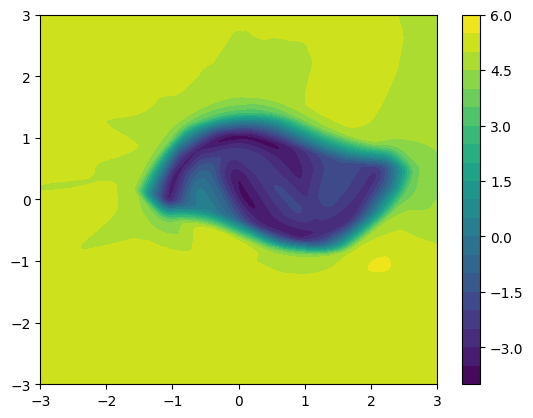

In [14]:
create_contour_plot_tensorflow(model)

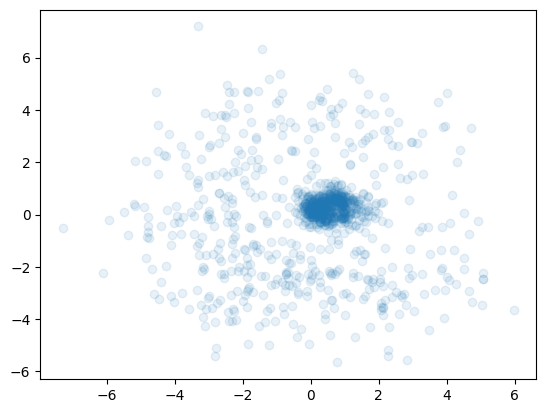

In [15]:
batch_size = 1000
x_init = tf.random.uniform((batch_size, 2), minval=-3, maxval=3)
sample = sgld_sample(model, x_init, tf.constant(50), 
                     150, 0.2, clip_thresh=tf.constant(0.1))
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1);

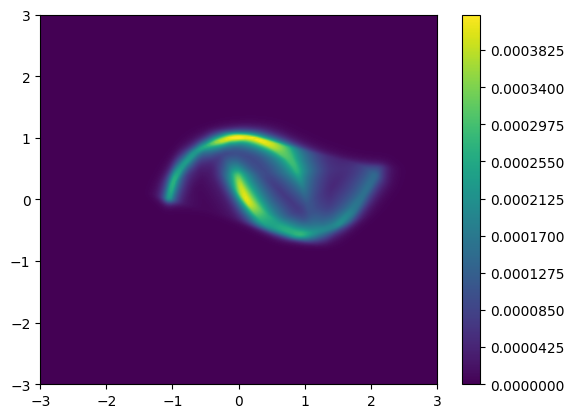

In [16]:
pdf = make_pdf_energy(model)

In [17]:
x = sample.numpy()

In [18]:
bins = 50
range_ = [[-2, 2], [-2, 2]]

hist_original, xedges, yedges = np.histogram2d(X[:, 0], X[:, 1], bins=bins, range=range_)
hist_generated, _, _ = np.histogram2d(x[:, 0], x[:, 1], bins=bins, range=range_)

epsilon = 1e-4
p_original = (hist_original + epsilon) / (hist_original.sum() + epsilon * bins * bins)
p_generated = (hist_generated + epsilon) / (hist_generated.sum() + epsilon * bins * bins)

p_original_flat = p_original.flatten()
p_generated_flat = p_generated.flatten()

kl_loss = tf.keras.losses.KLDivergence()
kl_value = kl_loss(p_original_flat, p_generated_flat).numpy()

print(f"KL-Divergence (Original || Generated): {kl_value:.4f}")

KL-Divergence (Original || Generated): 6.3640


In [19]:
print('distance: ', float(jensen_shannon_distance_kde(ebm.energy, pdf_kde)))

distance:  0.2494775371576825
